# Problem Statement

Jamboree has helped thousands of students to make it to top colleges abroad.
Be it GMAT, GRE or SAT, their unique problem-solving methods ensure maximum scores with minimum effort.
They recently launched a feature where students/learners can come to their website and check their probability of getting into the IVY league college. This feature estimates the chances of graduate admission from an Indian perspective.

How can we help here?

- Our analysis will help Jamboree in understanding what factors are important in graduate admissions and how these factors are interrelated among themselves.
- It will also help predict one's chances of admission given the rest of the variables.

# Data Dictionary
- **Serial No**. (Unique row ID)

- **GRE Scores** (out of 340)

- **TOEFL Scores** (out of 120)

- **University Rating** (out of 5)

- **Statement of Purpose and Letter of Recommendation Strength** (out of 5)

- **Undergraduate GPA** (out of 10)

- **Research Experience** (either 0 or 1)

- **Chance of Admit** (ranging from 0 to 1)

### Importing Libraries and Dataset

In [862]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import warnings
from regression_models import CustomLinearRegression
warnings.filterwarnings("ignore")

In [863]:
df = pd.read_csv("data/jamboree_admissions.csv")

In [864]:
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [865]:
df.columns

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit '],
      dtype='object')

In [866]:
# dropping the Serial No. column
df.drop(columns=['Serial No.'], inplace=True)
df.rename(columns={'LOR ':'LOR','Chance of Admit ':'Chance of Admit'}, inplace=True)

#### sanity check on dataset
- checking for null values
- checking for duplicates
- ensuring each column has their relevant data
- ensuring proper data types for each column

In [867]:
df.isnull().sum()

GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

- We do not see any null values in the dataset

In [868]:
df.duplicated().sum()

0

- We do not see any duplicate values in the dataset as well.

In [869]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          500 non-null    int64  
 1   TOEFL Score        500 non-null    int64  
 2   University Rating  500 non-null    int64  
 3   SOP                500 non-null    float64
 4   LOR                500 non-null    float64
 5   CGPA               500 non-null    float64
 6   Research           500 non-null    int64  
 7   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 31.4 KB


In [870]:
df.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA',
       'Research', 'Chance of Admit'],
      dtype='object')

In [871]:
# fixing the column name for LOR column
df.rename(columns = {'LOR ':'LOR'}, inplace=True)

In [872]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
GRE Score,500.0,316.47200,11.295148,290.00,308.0000,317.00,325.00,340.00
TOEFL Score,500.0,107.19200,6.081868,92.00,103.0000,107.00,112.00,120.00
University Rating,500.0,3.11400,1.143512,1.00,2.0000,3.00,4.00,5.00
SOP,500.0,3.37400,0.991004,1.00,2.5000,3.50,4.00,5.00
LOR,500.0,3.48400,0.925450,1.00,3.0000,3.50,4.00,5.00
CGPA,500.0,8.57644,0.604813,6.80,8.1275,8.56,9.04,9.92
Research,500.0,0.56000,0.496884,0.00,0.0000,1.00,1.00,1.00
Chance of Admit,500.0,0.72174,0.141140,0.34,0.6300,0.72,0.82,0.97


In [873]:
df['Research'].unique()

array([1, 0])

- We observe that all the data are numeric
- Upon inspection we do see presenece of some categorical data
    - **Research** - has mean 0.56 with min 0 and max 1
    - This indicates that it is a categorical column with 56% students with research experience
    - columns like **University Rating**,**LOR** and **SOP** which are nothing but assuming are discrete values (need to verify)

In [874]:
df['University Rating'].value_counts().sort_index()

University Rating
1     34
2    126
3    162
4    105
5     73
Name: count, dtype: int64

In [875]:
df['SOP'].value_counts().sort_index()

SOP
1.0     6
1.5    25
2.0    43
2.5    64
3.0    80
3.5    88
4.0    89
4.5    63
5.0    42
Name: count, dtype: int64

In [876]:
df['LOR'].value_counts().sort_index()

LOR
1.0     1
1.5    11
2.0    46
2.5    50
3.0    99
3.5    86
4.0    94
4.5    63
5.0    50
Name: count, dtype: int64

- **SOP**,**LOR** & **University Ranking** do look like categorical columns (ordinal)

#### performong exploratory analysis

In [877]:
df.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA',
       'Research', 'Chance of Admit'],
      dtype='object')

#### checking whether University Rating and People with research are significantly dependent

In [878]:
cross_tb = pd.crosstab(df['University Rating'],df['Research'])

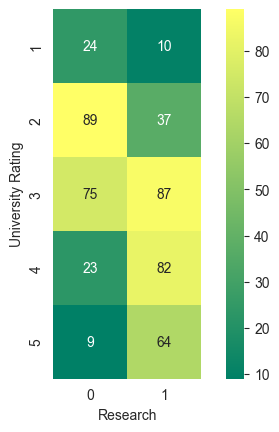

In [879]:
sns.heatmap(cross_tb, cmap='summer', square=True, annot=True)
plt.show()

- From the table we can observe that indeed university with higher ratings have more number of candidates with research experiecne

#### performing a chisquare test to validate the above


In [880]:
res = st.chi2_contingency(cross_tb)
if res.pvalue < 0.05:
    print("p-value is lesser than significance level.")
    print("Research is significantly related to University Rating")
else:
    print("p-value is higher than significance level.")
    print("Research is not significantly related to University Rating")

p-value is lesser than significance level.
Research is significantly related to University Rating


- Even the hypothesis test confirms that University Rating and Research are significantly related

#### determinig relation between LOR and SOP (if any)

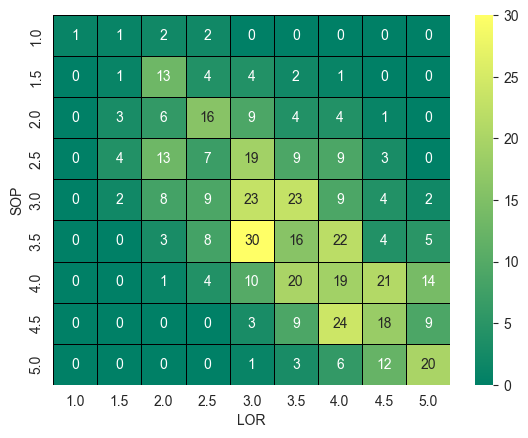

In [881]:
LOR_SOP_tab = pd.crosstab(df['SOP'],df['LOR'])
sns.heatmap(LOR_SOP_tab, cmap= 'summer', annot=True, linecolor='black', linewidths=0.5)
plt.show()

- As we see that there a tend from top left to bottom right.
- It mightindicate that as the SOP rating increases the LOR rayting increases as well.
- Lets do a ChiSquared test for independence to test the same.

In [882]:
chi_res = st.chi2_contingency(LOR_SOP_tab)
if chi_res.pvalue < 0.05:
    print("Rejecting Null Hyopthesis\nThere is a significant relation between LOR and SOP ratings")
else:
    print("Failed to Reject Null Hyopthesis\nThere is no significant relation between LOR and SOP ratings")

Rejecting Null Hyopthesis
There is a significant relation between LOR and SOP ratings


- Looks like as the LOP ratings increases the SOP Ratings also increases

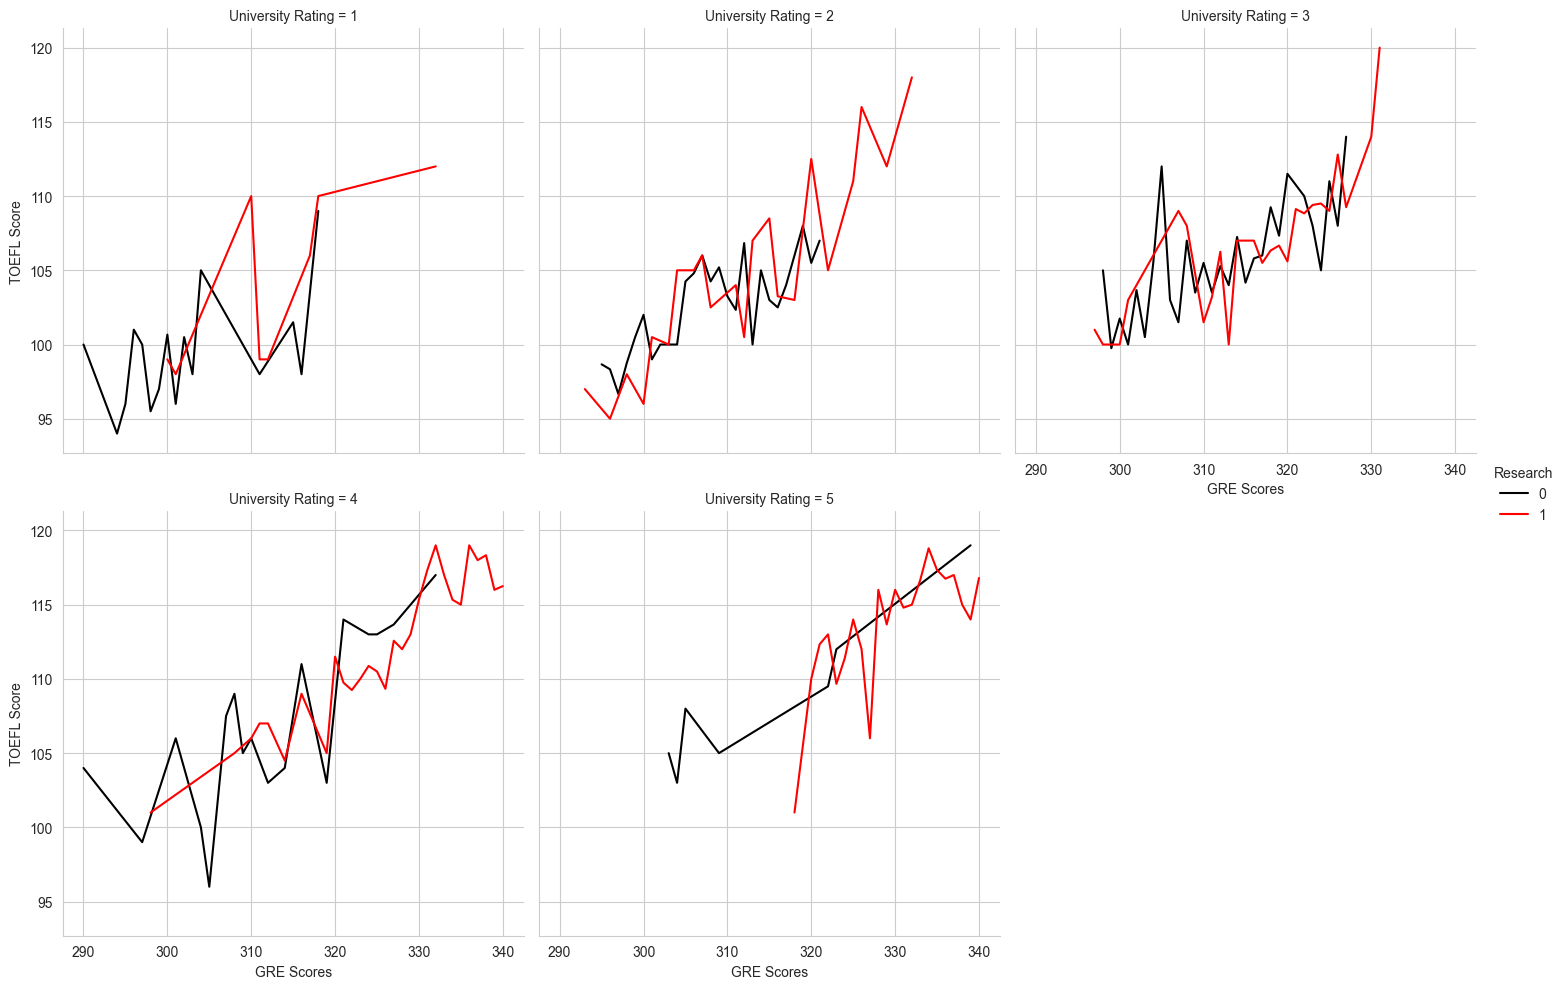

In [883]:
sns.set_style('whitegrid')
plot = sns.relplot(data = df,
            x='GRE Score',
            y = 'TOEFL Score',
            kind = 'line',
            col = 'University Rating',
            col_wrap=3,
            hue = 'Research',
            palette=['black', 'red'],
            ci = None)
plot.set_xlabels("GRE Scores")
plt.show()

- From the above we can see that irrespective of the University Rating as the TOEFL score is increasing,
GRE Score is also increasing

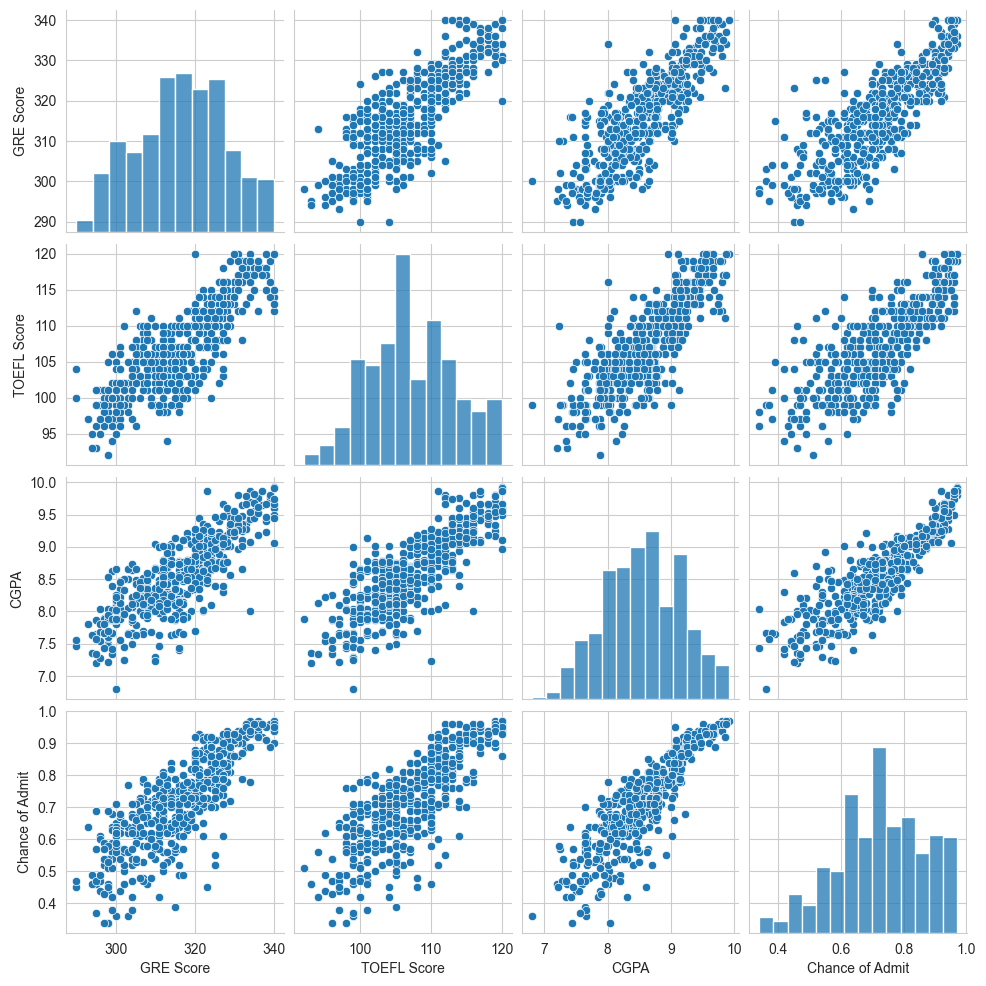

In [884]:
sns.pairplot(df[['GRE Score', 'TOEFL Score', 'CGPA', 'Chance of Admit']])
plt.show()

- We see that GRE Score, TOEFL Score, CGPA and Chance of admit are all positively correlated to each other.

#### checking whether the correlation between GRE Score and Chance of Admit is significant.

In [885]:
df.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA',
       'Research', 'Chance of Admit'],
      dtype='object')

In [886]:
df = df.rename(columns={'Chance of Admit ':'Chance of Admit'})

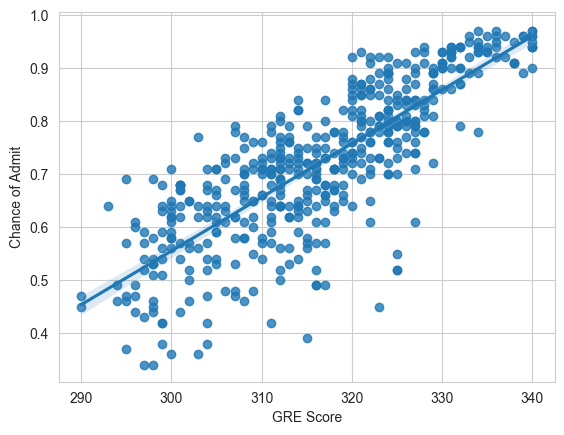

In [887]:
sns.regplot(data = df,
            x = 'GRE Score',
            y = 'Chance of Admit')
plt.show()

In [888]:
st.pearsonr(df['GRE Score'],df['Chance of Admit'])

PearsonRResult(statistic=0.8103506354632601, pvalue=1.0884036862476138e-117)

- GRE Score and Chance of Admit has a high positive correlation
- A candidate needs to have a good GRE Score to increase their chances of admission.

#### checking whether students with research experience have a higher Chance of Admit compared to those without research experience

In [889]:
research = df.query('Research == 1')['Chance of Admit']
no_research = df.query('Research == 0')['Chance of Admit']

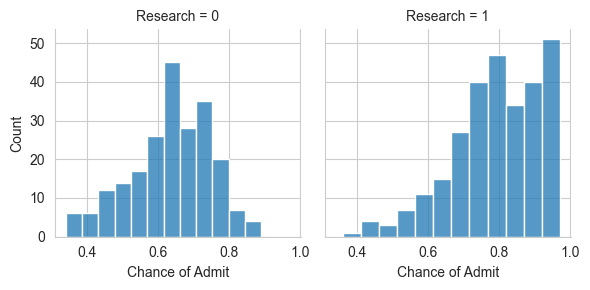

In [890]:
# performing ttest to validate the above
# checking assumptions for ttest
# 1. Normality of data
g = sns.FacetGrid(df, col='Research')
g.map(sns.histplot, 'Chance of Admit')
plt.show()

In [891]:
res_p = st.shapiro(research.sample(100))
no_res_p = st.shapiro(no_research.sample(100))

In [892]:
res_p.pvalue, no_res_p.pvalue

(0.0002782303490675986, 0.07865913957357407)

- Conclusion of Shapiro Wilk's Test
    - data for research is right skewed
    - data for no research students follows normal distribution

In [893]:
# 2. Checking for equality of variance
# conducting leven's test
st.levene(research, no_research)

LeveneResult(statistic=2.291641098174848, pvalue=0.130706702224074)

- We can see that the p-value is greater than significance level of 5%
- We can conclude that both data have equal variances

In [894]:
research.mean(), no_research.mean()

(0.7899642857142857, 0.634909090909091)

In [895]:
# performing ttest
ttest_res = st.ttest_ind(research, no_research, alternative='greater')

if ttest_res.pvalue<0.05:
    print("Mean of chances of admission is higher for candidates with research experience")
else:
    print("Mean of chances of admission not higher for candidates with research experience")

Mean of chances of admission is higher for candidates with research experience


- Looks like candidates with research experience have higher chance of admissions

#### checking whether chance of admit is different across various university ratings

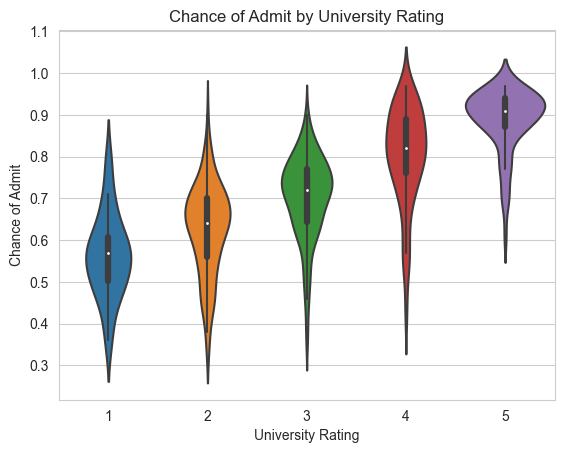

In [896]:
sns.violinplot(x='University Rating', y='Chance of Admit', data=df)
plt.title('Chance of Admit by University Rating')
plt.show()

In [897]:
uni_1 = df[df['University Rating'] == 1]['Chance of Admit']
uni_2 = df[df['University Rating'] == 2]['Chance of Admit']
uni_3 = df[df['University Rating'] == 3]['Chance of Admit']
uni_4 = df[df['University Rating'] == 4]['Chance of Admit']
uni_5 = df[df['University Rating'] == 5]['Chance of Admit']

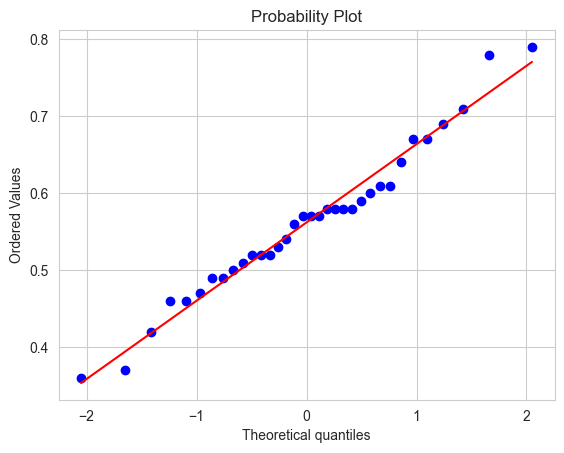

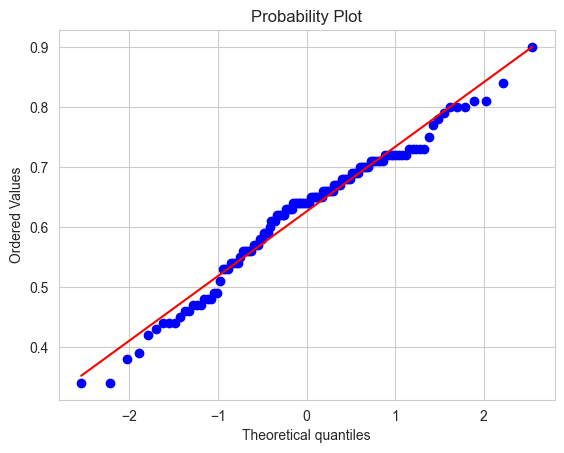

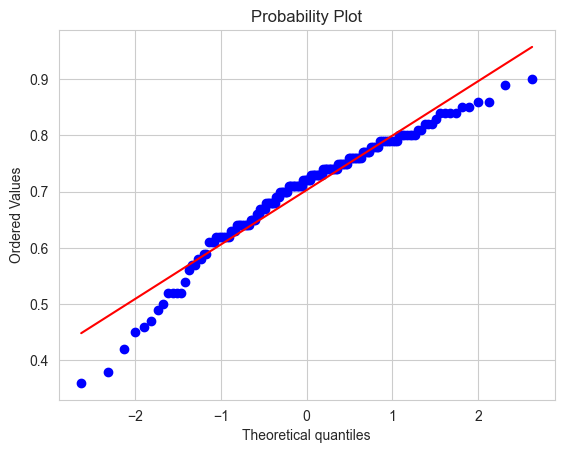

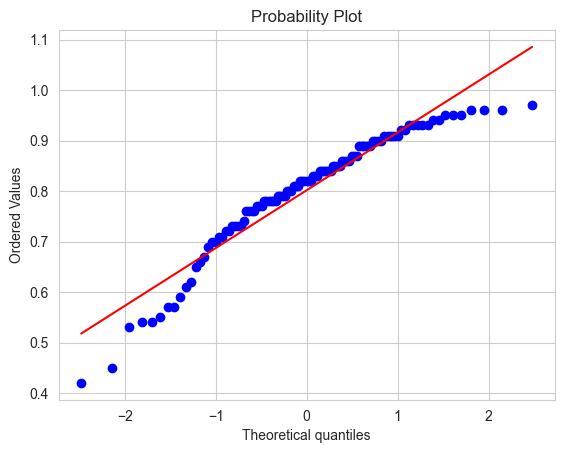

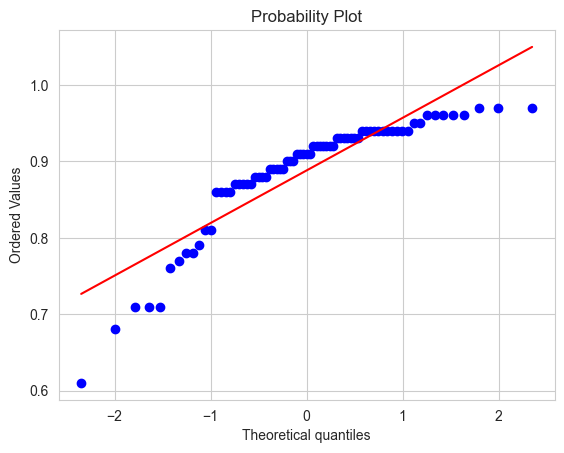

In [898]:
# checking assumptions for ANOVA one-way test
# checking for normality
data = [uni_1, uni_2, uni_3, uni_4, uni_5]
for dt in data:
    st.probplot(dt, dist="norm", plot=plt)
    plt.show()

In [899]:
# performing KS test for Normality
p_vals = []
for dt in data:
    p = st.kstest(dt, 'norm', args = (dt.mean(), dt.std()))
    p_vals.append(p.pvalue)
res = np.where(np.array(p_vals) < 0.05, 'Not Normal', 'Normal')
list(res)

['Normal', 'Normal', 'Not Normal', 'Normal', 'Not Normal']

- For University Rating 3, 4 and 5, the data is not normal

In [900]:
# checking for equality of variance
st.levene(*data)

LeveneResult(statistic=3.522000386517165, pvalue=0.007557389989660351)

- Even the data have heterogenous variances

In [901]:
# will perform Kruskal Wallis test
st.kruskal(*data)

KruskalResult(statistic=250.45816869447793, pvalue=5.186317808975006e-53)

- Since the p-value is less than 5% significance level, it can be concluded that the University Rating indeed affects the Chance of Admit

In [902]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
GRE Score,500.0,316.47200,11.295148,290.00,308.0000,317.00,325.00,340.00
TOEFL Score,500.0,107.19200,6.081868,92.00,103.0000,107.00,112.00,120.00
University Rating,500.0,3.11400,1.143512,1.00,2.0000,3.00,4.00,5.00
SOP,500.0,3.37400,0.991004,1.00,2.5000,3.50,4.00,5.00
LOR,500.0,3.48400,0.925450,1.00,3.0000,3.50,4.00,5.00
CGPA,500.0,8.57644,0.604813,6.80,8.1275,8.56,9.04,9.92
Research,500.0,0.56000,0.496884,0.00,0.0000,1.00,1.00,1.00
Chance of Admit,500.0,0.72174,0.141140,0.34,0.6300,0.72,0.82,0.97


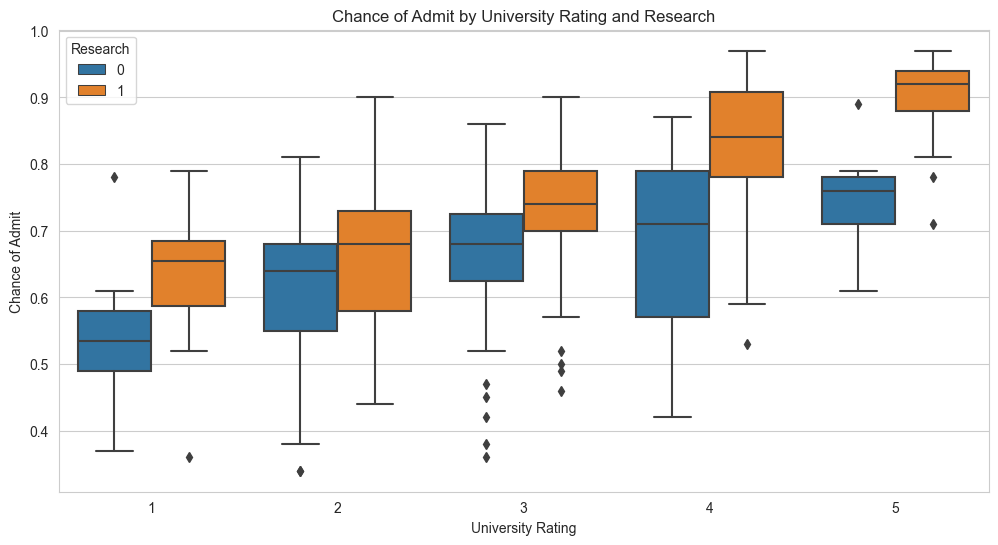

In [903]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='University Rating', y='Chance of Admit', hue='Research', data=df)
plt.title('Chance of Admit by University Rating and Research')
plt.show()

In [904]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Chance of Admit']), df['Chance of Admit'],\
                                                    test_size=0.2, shuffle=True)

In [905]:
X_train

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
38,304,105,1,3.0,1.5,7.50,0
310,320,104,3,3.0,3.5,8.74,1
101,312,105,2,2.5,3.0,8.12,0
169,311,99,2,2.5,3.0,7.98,0
400,304,100,2,3.5,3.0,8.22,0
...,...,...,...,...,...,...,...
121,334,119,5,4.5,4.5,9.48,1
490,307,105,2,2.5,4.5,8.12,1
147,326,114,3,3.0,3.0,9.11,1
444,324,113,5,4.0,5.0,9.25,1


#### standardizing the dataset

In [906]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
cols= X_train.columns
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [907]:
X_train_std = pd.DataFrame(X_train_std, columns=cols)

In [908]:
X_train_std.describe().T

,count,mean,std,min,25%,50%,75%,max
GRE Score,400.0,6.084022e-16,1.001252,-2.403634,-0.786689,0.021784,0.740426,2.087881
TOEFL Score,400.0,-1.150191e-15,1.001252,-2.594832,-0.744984,-0.072312,0.768528,2.113871
University Rating,400.0,1.865175e-16,1.001252,-1.853528,-0.985365,-0.117202,0.750961,1.619124
SOP,400.0,-1.265654e-16,1.001252,-2.395671,-0.885001,0.122113,0.625669,1.632783
LOR,400.0,1.004752e-16,1.001252,-2.705185,-0.545357,-0.005400,0.534558,1.614472
CGPA,400.0,-1.393330e-15,1.001252,-2.963038,-0.777058,-0.006997,0.767204,2.203824
Research,400.0,1.154632e-16,1.001252,-1.175139,-1.175139,0.850963,0.850963,0.850963


- We can see that mean are nearly 0 and standard deviations are 1

#### training some regression models using SKLearn library

In [909]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
def adjusted_r2(r2,n ,p):
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))



def run_simulation(lasso_alpha, ridge_alpha):
    models = [('Linear Regression',LinearRegression()),
          ('Lasso Regression', Lasso(alpha=lasso_alpha)),
          ('Rigde Regression', Ridge(alpha = ridge_alpha))]
    for name, model in models:
        model.fit(X_train_std, y_train)
        predictions = model.predict(scaler.transform(X_test))
        print("-"*20+f"Model : {name}"+"-"*20)
        print(f"MSE : {round(mean_squared_error(predictions, y_test),5)}")
        print(f"MAE : {round(mean_absolute_error(predictions, y_test),5)}")
        print(f"R2 score : {round(r2_score(predictions, y_test),5)}")
        print(f"Adjusted R2 score : {round(adjusted_r2(r2_score(predictions, y_test), X_test.shape[0], X_test.shape[1]),5)}")

In [910]:
run_simulation(0.1,1)

--------------------Model : Linear Regression--------------------
MSE : 0.00271
MAE : 0.03755
R2 score : 0.83653
Adjusted R2 score : 0.82409
--------------------Model : Lasso Regression--------------------
MSE : 0.01511
MAE : 0.09594
R2 score : -28.95924
Adjusted R2 score : -31.23874
--------------------Model : Rigde Regression--------------------
MSE : 0.00271
MAE : 0.03758
R2 score : 0.83605
Adjusted R2 score : 0.82358


In [911]:
run_simulation(0.5,0.8)

--------------------Model : Linear Regression--------------------
MSE : 0.00271
MAE : 0.03755
R2 score : 0.83653
Adjusted R2 score : 0.82409
--------------------Model : Lasso Regression--------------------
MSE : 0.02057
MAE : 0.11217
R2 score : -1.6685683259094032e+30
Adjusted R2 score : -1.795524611576423e+30
--------------------Model : Rigde Regression--------------------
MSE : 0.00271
MAE : 0.03757
R2 score : 0.83615
Adjusted R2 score : 0.82368


In [912]:
run_simulation(0.9,2)

--------------------Model : Linear Regression--------------------
MSE : 0.00271
MAE : 0.03755
R2 score : 0.83653
Adjusted R2 score : 0.82409
--------------------Model : Lasso Regression--------------------
MSE : 0.02057
MAE : 0.11217
R2 score : -1.6685683259094032e+30
Adjusted R2 score : -1.795524611576423e+30
--------------------Model : Rigde Regression--------------------
MSE : 0.00271
MAE : 0.0376
R2 score : 0.83558
Adjusted R2 score : 0.82307


#### Linear Regression using StatsModels

In [913]:
import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train_std)
model = sm.OLS(y_train.values, X_train_sm).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     236.9
Date:                Fri, 07 Jun 2024   Prob (F-statistic):          1.45e-136
Time:                        21:04:16   Log-Likelihood:                 548.58
No. Observations:                 400   AIC:                            -1081.
Df Residuals:                     392   BIC:                            -1049.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.7240      0.00

- P value for f_stat is much less than 5% signifying the overall model is a good fit
- We see for columns like SOP and University Rating the p-value is greater the significance Level of 5%
- This means that the coeff of these features are not that significant in predictions. Hence can be removed
- R2 and adjusted R2 are 80.9% and 80.5% respectively. Seems like a good enough number.

In [914]:
#### checking the VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(data):

    # Add a constant (intercept term) to the model
    X = sm.add_constant(data)

    # Calculate VIF for each predictor variable
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return vif_data


In [915]:
calculate_vif(X_train_std)

,Feature,VIF
0,const,1.000000
1,GRE Score,4.402615
2,TOEFL Score,4.208491
3,University Rating,2.741429
4,SOP,2.956010
5,LOR,2.086330
6,CGPA,4.569282
7,Research,1.442589


- VIF for all the features are less than 5
- We are good from the perpective of Multicollinearity

In [916]:
X_train_std

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,-1.146010,-0.408648,-1.853528,-0.381444,-2.165228,-1.803806,-1.175139
1,0.291275,-0.576816,-0.117202,-0.381444,-0.005400,0.249690,0.850963
2,-0.427368,-0.408648,-0.985365,-0.885001,-0.545357,-0.777058,-1.175139
3,-0.517198,-1.417656,-0.985365,-0.885001,-0.545357,-1.008904,-1.175139
4,-1.146010,-1.249488,-0.985365,0.122113,-0.545357,-0.611453,-1.175139
...,...,...,...,...,...,...,...
395,1.548899,1.945703,1.619124,1.129226,1.074515,1.475164,0.850963
396,-0.876519,-0.408648,-0.985365,-0.885001,1.074515,-0.777058,0.850963
397,0.830257,1.104864,-0.117202,-0.381444,-0.545357,0.862427,0.850963
398,0.650596,0.936696,1.619124,0.625669,1.614472,1.094273,0.850963


In [917]:
# dropping the columns with p_value of coeff greater than 0.05
X_train_std.drop(columns = ['SOP', 'University Rating'], inplace=True)
X_test_std = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X_test_std.drop(columns = ['SOP','University Rating'], inplace=True)


In [918]:
X_train_std

,GRE Score,TOEFL Score,LOR,CGPA,Research
0,-1.146010,-0.408648,-2.165228,-1.803806,-1.175139
1,0.291275,-0.576816,-0.005400,0.249690,0.850963
2,-0.427368,-0.408648,-0.545357,-0.777058,-1.175139
3,-0.517198,-1.417656,-0.545357,-1.008904,-1.175139
4,-1.146010,-1.249488,-0.545357,-0.611453,-1.175139
...,...,...,...,...,...
395,1.548899,1.945703,1.074515,1.475164,0.850963
396,-0.876519,-0.408648,1.074515,-0.777058,0.850963
397,0.830257,1.104864,-0.545357,0.862427,0.850963
398,0.650596,0.936696,1.614472,1.094273,0.850963


In [919]:
X_test_std

,GRE Score,TOEFL Score,LOR,CGPA,Research
0,-1.595161,-0.240480,0.534558,-0.313365,-1.175139
1,-1.595161,-1.249488,-1.625271,-0.942662,-1.175139
2,-0.966349,0.432192,0.534558,-0.230563,-1.175139
3,-0.068046,-1.081320,-1.625271,-0.445849,0.850963
4,-0.427368,-0.744984,1.614472,-0.263684,-1.175139
...,...,...,...,...,...
95,1.189578,1.273031,-0.545357,1.243317,0.850963
96,0.470935,0.432192,0.534558,0.845867,0.850963
97,0.740426,0.432192,0.534558,0.614020,0.850963
98,-0.427368,-0.240480,1.614472,-0.031837,-1.175139


In [920]:
X_train_sm = sm.add_constant(X_train_std)
model_1 = sm.OLS(y_train.values, X_train_sm).fit()
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     329.3
Date:                Fri, 07 Jun 2024   Prob (F-statistic):          3.07e-138
Time:                        21:04:16   Log-Likelihood:                 546.59
No. Observations:                 400   AIC:                            -1081.
Df Residuals:                     394   BIC:                            -1057.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.7240      0.003    232.890      

- Post removal of the columns we see that the R2 and Adj R2 are still approx to what we had before removing i.e. 80.7% and 80.4% respectively.

In [924]:
#### checking the various metrics
predictions = model_1.predict(sm.add_constant(X_test_std))
print(f"MSE : {round(mean_squared_error(y_test, predictions),5)}")
print(f"MAE : {round(mean_absolute_error(y_test, predictions),5)}")
print(f"R2 Score : {round(r2_score(y_test, predictions),5)}")
print(f"Adjusted R2 score : {round(adjusted_r2(r2_score(predictions, y_test), X_test.shape[0], X_test.shape[1]),5)}")

MSE : 0.00265
MAE : 0.03707
R2 Score : 0.87023
Adjusted R2 score : 0.82972


### Checking for assumptions of Linear Regression

#### Normality of Residuals

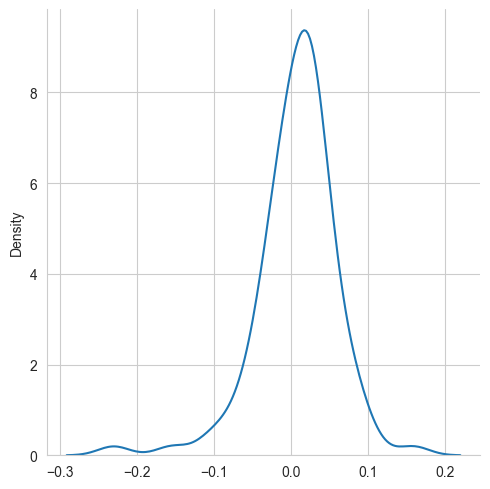

In [925]:
residuals = y_test.values - predictions
sns.displot(residuals,kind='kde')
plt.show()

In [926]:
# perform KS test to check for Normality
res = st.kstest(residuals,'norm', args = (residuals.mean(), residuals.std()))
res.pvalue

0.326844780906987

- We see that the p_value is greater than 5%
- We can conclude that the residuals are normally distributed

#### Homoscedascity

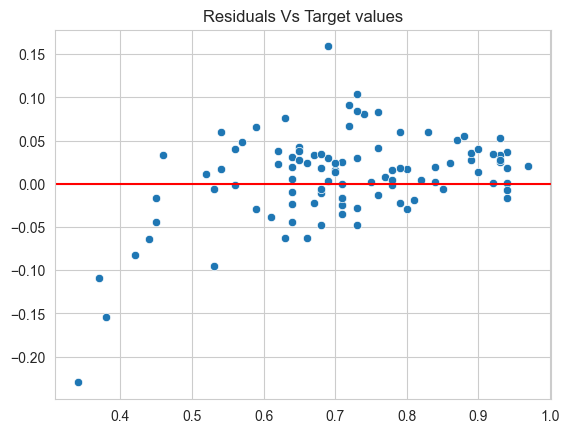

In [927]:
sns.scatterplot(x = y_test.values, y=residuals)
plt.axhline(y = 0, color = 'r')
plt.title('Residuals Vs Target values')
plt.show()

In [928]:
# using golfeld quandt test
import statsmodels.stats.api as sm
test = sm.het_goldfeldquandt(residuals, X_test)
_,p_val,_ = test

if p_val > 0.05:
    print('Residuals are Homoscedastic')
else:
    print('Residuals are Heteroscedastic')

Residuals are Homoscedastic


- We did goldfeld quandt test and thus confirm that residuals are homoscedastic

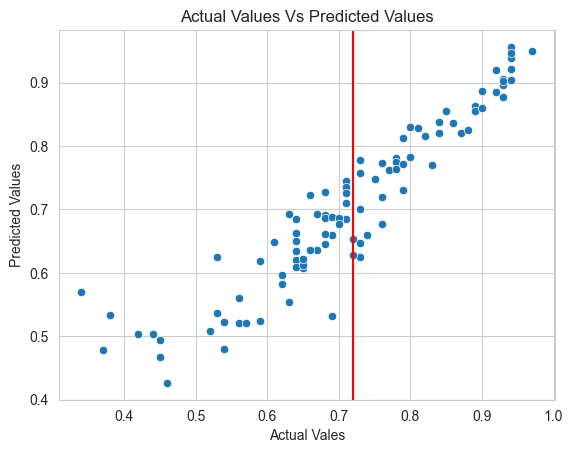

In [930]:
sns.scatterplot(x = y_test.values, y = predictions)
plt.xlabel('Actual Vales')
plt.ylabel('Predicted Values')
plt.title('Actual Values Vs Predicted Values')
plt.axvline(x = 0.72, color = 'r')
plt.show()

- We see that for higher chances of admit, the model is performing better (lesser variance).
- Where chances of admit is less (approx < 0.72) of actual values, we see higher variance.


### Insights
**University Rating and Research Experience**

- Higher-rated universities have more candidates with research experience.
- Chi-squared test confirmed a significant relationship between University Rating and Research.

**LOR and SOP Relationship**

- Positive trend observed: higher SOP ratings correspond with higher LOR ratings.
- Chi-squared test confirmed a significant relationship between LOR and SOP.

**GRE and TOEFL Scores**

- Positive correlation observed: higher TOEFL scores correspond with higher GRE scores.

**Pair Plot Analysis**

- GRE Score, TOEFL Score, CGPA, and Chance of Admit are positively correlated.

**Correlation between GRE Score and Chance of Admit**

- High positive correlation (Pearson's r = 0.81).
- Scatter plot confirmed this relationship.

**Impact of Research on Chance of Admit**

- Candidates with research experience have a higher mean chance of admission.
- T-test confirmed that research experience significantly increases the chance of admission.

**Model Training**

- Three models were trained: Linear Regression, Lasso Regression, and Ridge Regression.
- Linear Regression performed best with an adjusted R-squared of 0.824.
- Lasso Regression had issues due to improper alpha selection, leading to poor performance.

**StatsModels Linear Regression**

- Overall Model Fit:
- R-squared: 0.809
- Adjusted R-squared: 0.805
- The overall model fit was good, indicated by a low p-value for the F-statistic.

**Significant Predictors**
- GRE Score (p < 0.05)
- TOEFL Score (p < 0.05)
- LOR (Letter of Recommendation) (p < 0.05)
- CGPA (Undergraduate GPA) (p < 0.05)
- Research Experience (p < 0.05)

**Non-significant Predictors**

- SOP (Statement of Purpose) (p > 0.05)
- University Rating (p > 0.05)
- These non-significant predictors were removed in subsequent models.

**Final Model After Removing Non-significant Predictors**

- R-squared: 0.807
- Adjusted R-squared: 0.804
- Significant predictors remained the same: GRE Score, TOEFL Score, LOR, CGPA, and Research Experience.


**Metrics for Final Model**

- Mean Squared Error (MSE): 0.00265
- Mean Absolute Error (MAE): 0.03707
- R2 Score: 0.87023
- Adjusted R2 Score: 0.82972

**Multicollinearity Check Using VIF**

- VIF values for all predictors were less than 5, indicating no significant multicollinearity issues.

**Assumptions Checking**

- Linearity
    - No pattern of residuals observed confirming that linearity assumption holds true.

- Normality of Residuals:
    - Residuals were normally distributed (p-value > 0.05 from KS test).

- Homoscedasticity:
    - Residuals were homoscedastic (confirmed by the Goldfeld-Quandt test).

- Multicollinearity
    - VIF values for all predictors were less than 5, indicating no significant multicollinearity issues.

**Predictions VS Actuals**

- It was observed that below 0.7 of actual value the variance between predictions and actuals is quiet high
- To rectify this, we can have more data for the specified region
- We can make our model more complex to capture this variation

